In [1]:
import load
import oed
import figure

In [2]:
# jsonファイルの読み込み
result = load.load_result_json("../result/Result.json")

gene = result[0]["gene"]

N, M, theta, w_on, w_off, w, g, w_osc, w_nmj = oed.weight(gene)
alpha, x_peak, y_peak, dt, T, f, v, time, tau = oed.constant("setting")
N_, M_, f_inv, T_ = oed.time_constant_step(gene, "setting")

# figure.trajectory(gene, 10)
# figure.newron_output(gene)

# figure.Bearing_vs_Turing_bias("../output/b_vs_t.txt", "../figure/Bearing_vs_Turing_bias.png")
# figure.Normal_gradient_vs_Turing_bias("../output/n_vs_t.txt", "../figure/Normal_gradient_vs_Turing_bias")
# figure.Translational_gradient_vs_Turing_bias("../output/t_vs_t.txt", "../figure/Translational_gradient_vs_Turing_bias")
# figure.trajectory(gene, 10, 7, "../figure/Trajectory_colorbar")

In [ ]:
result = load.load_result_json("../result/Result.json")
file_path_base = "../figure/connectome/connectome_"
for i in range(10):
    gene = result[i]["gene"]
    file_path = file_path_base + str(i)
    figure.connectome(gene, file_path)

In [ ]:
result = load.load_result_json("../result/Result.json")
file_path_base = "../figure/newron/newron_"
for i in range(10):
    gene = result[i]["gene"]
    file_path = file_path_base + str(i)
    figure.newron_output(gene, file_path)

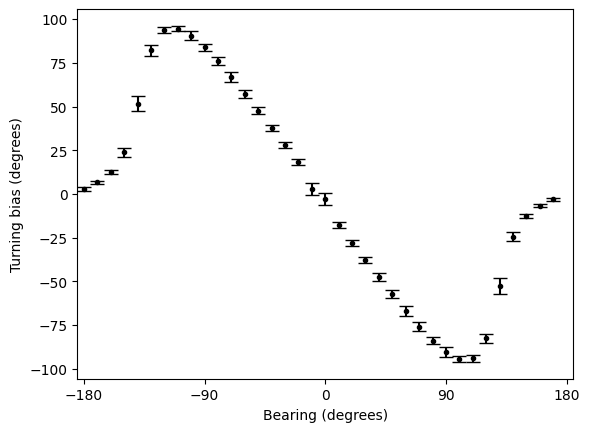

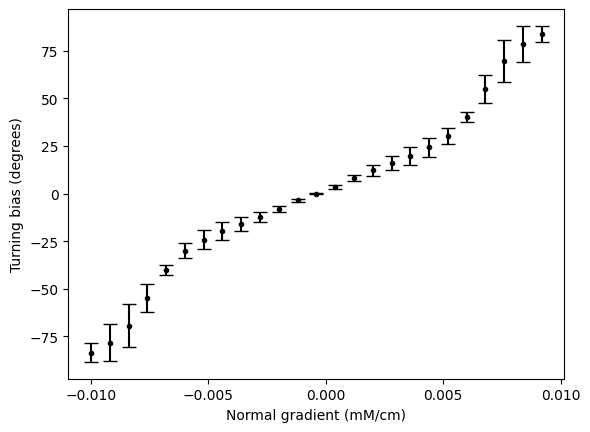

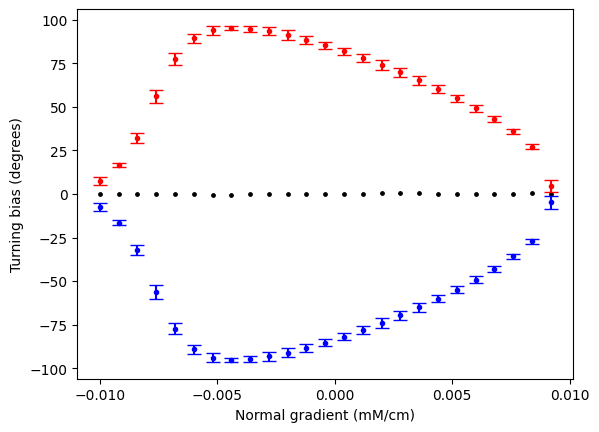

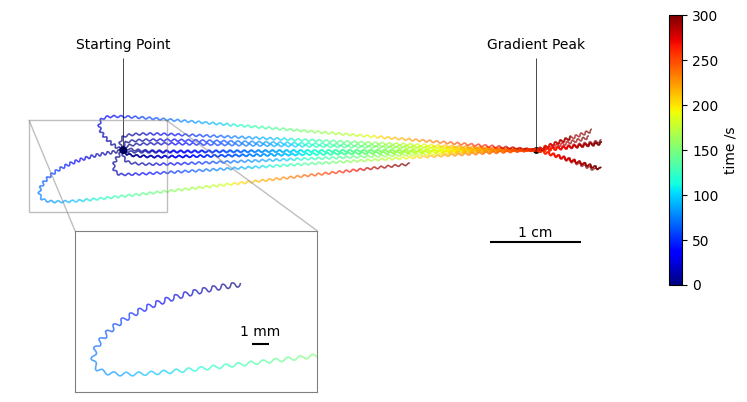

In [6]:
figure.Bearing_vs_Turing_bias(
    "../output/b_vs_t_bc.txt", "../figure/Bearing_vs_Turing_bias.png"
)

figure.Normal_gradient_vs_Turing_bias(
    "../output/n_vs_t_bc.txt", "../figure/Normal_gradient_vs_Turing_bias.png"
)

figure.Translational_gradient_vs_Turing_bias(
    "../output/t_vs_t_bc.txt", "../figure/Translational_gradient_vs_Turing_bias.png"
)

figure.trajectory(gene, 10, 7, "../figure/Trajectory_colorbar.png")

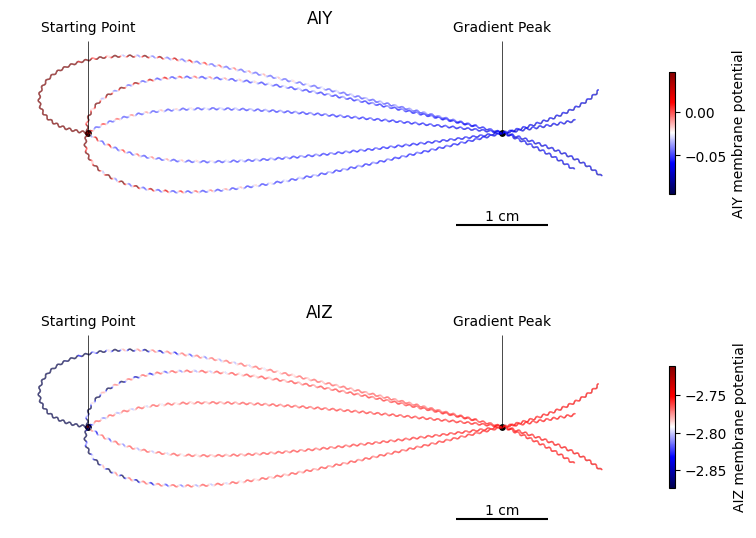

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import oed
import load
import figure


def trajectory_membrane_potential(gene, lines_number, out_file_path):
    fig, ax = plt.subplots(2, 1, figsize=(10, 7))

    top = 0
    bottom = 1
    cmap = "seismic"

    step = 2 * np.pi / lines_number

    all_lines = []
    all_aiy = []
    all_aiz = []

    # トラジェクトリーの解析
    for angle in np.arange(0, 2 * np.pi, step):
        r, y = oed.klinotaxis_membrane_potential(gene, angle)
        alpha, x_peak, y_peak, dt, T, f, v, time, tau = oed.constant("setting")

        lines = figure.single_line_stacks(r[0], r[1])
        aiy = (y[0] + y[1]) / 2
        aiz = (y[2] + y[3]) / 2

        all_lines.append(lines)
        all_aiy.append(aiy)
        all_aiz.append(aiz)

    flat_aiy = np.array(all_aiy).flatten()
    flat_aiz = np.array(all_aiz).flatten()

    mean_aiy = np.mean(flat_aiy)
    std_dev_aiy = np.std(flat_aiy)
    mean_aiz = np.mean(flat_aiz)
    std_dev_aiz = np.std(flat_aiz)

    # AIYの表示
    for i, lines in enumerate(all_lines):
        lc = LineCollection(
            lines,
            cmap=cmap,
            norm=Normalize(vmin=mean_aiy - std_dev_aiy, vmax=mean_aiy + std_dev_aiy),
            linewidth=1,
            array=all_aiy[i],
        )
        line_aiy = ax[top].add_collection(lc)

    # AIZの表示
    for i, lines in enumerate(all_lines):
        lc = LineCollection(
            lines,
            cmap=cmap,
            norm=Normalize(vmin=mean_aiz - std_dev_aiz, vmax=mean_aiz + std_dev_aiz),
            linewidth=1,
            array=all_aiz[i],
        )
        line_aiz = ax[bottom].add_collection(lc)

    # スタートとゴールの表示
    starting_point = [0, 0]
    peak = [x_peak, y_peak]

    for i in [top, bottom]:
        ax[i].scatter(*starting_point, s=15, color="black")
        ax[i].scatter(*peak, s=15, color="black")

        y_max = 1
        ax[i].vlines(
            starting_point[0],
            starting_point[1],
            y_max,
            color="black",
            linestyle="-",
            linewidth=0.5,
        )
        ax[i].vlines(
            peak[0], peak[1], y_max, color="black", linestyle="-", linewidth=0.5
        )

        ax[i].text(
            starting_point[0],
            y_max + 0.1,
            "Starting Point",
            horizontalalignment="center",
        )
        ax[i].text(peak[0], y_max + 0.1, "Gradient Peak", horizontalalignment="center")

    # 軸メモリや枠を非表示にする
    for i in [top, bottom]:
        ax[i].axis("off")
        ax[i].autoscale()
        ax[i].set_aspect("equal")

    # 基準の大きさを表示
    for i in [top, bottom]:
        ax[i].text(4.5, -0.95, "1 cm", horizontalalignment="center")
        ax[i].hlines(-1, 4, 5, color="black", linestyle="-", linewidth=1.5)

    # カラーバー表示
    plt.colorbar(line_aiy, ax=ax[top], label="AIY membrane potential", shrink=0.5)
    plt.colorbar(line_aiz, ax=ax[bottom], label="AIZ membrane potential", shrink=0.5)

    # タイトルの表示
    ax[top].set_title("AIY")
    ax[bottom].set_title("AIZ")

    # グラフの保存および表示
    plt.savefig(out_file_path, dpi=300)
    plt.show()

    return


trajectory_membrane_potential(gene, 5, 1, 1)